In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
I = np.array([[1, 0],[0,1]])
X = np.array([[0,1],[1,0]])
H = (1/(np.sqrt(2))) * np.array([[1,1], [1, -1]])
CNOT = np.array([[1, 0, 0, 0],[0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])

# Projector matrices for CNOTs
P0 = np.array([[1, 0],[0,0]])
P1 = np.array([[0, 0],[0,1]])

In [3]:
def init_sv(num_qubits: int) -> np.array:
    """Initialize the state vector and set the value to zero"""
    sv = np.zeros(2**num_qubits)
    # init state vector to 0
    sv[0] = 1
    return sv

def operate_on_sv(operation, qubits, statevector: np.array) -> np.array:
    """Performs the operation on the statevector 

    Args:
        operation: Operation to perform
        qubits: an int or list of ints representing the qubits to be acted on
        statevector: current statevector

    Returns:
        The new statevector after the operation
    """
    qubits = [qubits] if isinstance(qubits, int) else qubits

    total_number_qubits = int(np.log2(len(statevector)))

    # Handle error cases
    if len(qubits) > 2:
        raise AttributeError("qubits can contain at max 2 values")
    elif(len(qubits) == 2 and not np.array_equal(operation, CNOT)):
        raise AttributeError("only 2 qubit gate is CNOT")
    elif(not all(q in range(1, total_number_qubits+1) for q in qubits)):
        raise AttributeError("Qubits to act upon are not valid. If an operation acts upon a single qubit please enter an integer. If the operation acts on two qubit, include a list of integers with the first integer being the control and the second integer being the target.")

    # Handle CNOT case
    elif(len(qubits) == 2):
        control_is_zero = []
        control_is_one = []
        for i in range(1, total_number_qubits+1):
            # control qubit
            if i == qubits[0]:
                control_is_zero.append(P0)
                control_is_one.append(P1)
            # target qubit
            elif i == qubits[1]:
                control_is_zero.append(I)
                control_is_one.append(X)
            else:
                control_is_zero.append(I)
                control_is_one.append(I)
        
        # Control is zero Kronecker product
        control_zero_matrix = np.kron(control_is_zero[0], control_is_zero[1])
        for i in range(2, total_number_qubits):
            control_zero_matrix = np.kron(control_zero_matrix, control_is_zero[i])

        # Control is one Kronecker product
        control_one_matrix = np.kron(control_is_one[0], control_is_one[1])
        for i in range(2, total_number_qubits):
            control_one_matrix = np.kron(control_one_matrix, control_is_one[i])

        return np.dot(np.add(control_zero_matrix, control_one_matrix), statevector.transpose())
    
    # Handle single qubit operations
    else:
        operation_krons = []
        for i in range(1, total_number_qubits+1):
            # operation qubit
            if i == qubits[0]:
                operation_krons.append(operation)
            else:
                operation_krons.append(I)

        # piece together the Kronecker product
        operation_matrix = np.kron(operation_krons[0], operation_krons[1])
        for i in range(2, total_number_qubits):
            operation_matrix = np.kron(operation_matrix, operation_krons[i])

        return np.dot(operation_matrix, statevector.transpose())

        


In [4]:
num_qubits = 3
statevector = init_sv(num_qubits)
statevector = operate_on_sv(X, 1, statevector)
statevector = operate_on_sv(H, 1, statevector)
statevector = operate_on_sv(CNOT, [1, 2], statevector)
print(statevector)

[ 0.70710678  0.          0.          0.          0.          0.
 -0.70710678  0.        ]


In [5]:
def run_sv_experiment(num_qubits: int):
    """Runs the predetermined experiment of X, H, and CNOT operations.
    The time it takes to run the operations is saved and returned
    
    Args:
        num_qubits: how many qubits to use with the experiment
        
    Returns:
        Time in seconds it took to run the operations
    """

    # determine X, H, control, and target qubits at random before starting
    control_qubit, target_qubit = np.random.randint(1, num_qubits+1, 2)
    x_qubit = np.random.randint(1, num_qubits+1, 1)
    h_qubit = np.random.randint(1, num_qubits+1, 1)
    start_time = time.time()
    statevector = init_sv(num_qubits)
    statevector = operate_on_sv(X, x_qubit, statevector)
    statevector = operate_on_sv(H, h_qubit, statevector)
    statevector = operate_on_sv(CNOT, [control_qubit,target_qubit], statevector)
    return(time.time()-start_time, x_qubit, h_qubit, control_qubit, target_qubit)

In [29]:
sv_results = {}

# Starting at 16 qubits the kernel crashes 
for num_qubits in range(2, 16):
    sv_results[num_qubits] = run_sv_experiment(num_qubits)


for qubit, result in sv_results.items():
    print(f"{qubit} qubits - {result[0]} seconds")

2 qubits - 0.00021028518676757812 seconds
3 qubits - 0.0001621246337890625 seconds
4 qubits - 0.0002548694610595703 seconds
5 qubits - 0.0012977123260498047 seconds
6 qubits - 0.0006270408630371094 seconds
7 qubits - 0.01783466339111328 seconds
8 qubits - 0.012953042984008789 seconds
9 qubits - 0.026276826858520508 seconds
10 qubits - 0.03568220138549805 seconds
11 qubits - 0.1551649570465088 seconds
12 qubits - 0.6112937927246094 seconds
13 qubits - 2.5716888904571533 seconds
14 qubits - 10.541647911071777 seconds
15 qubits - 45.27706599235535 seconds


Text(0.5, 1.0, 'Runtime of operations with a state vector as a function of Number of Qubits')

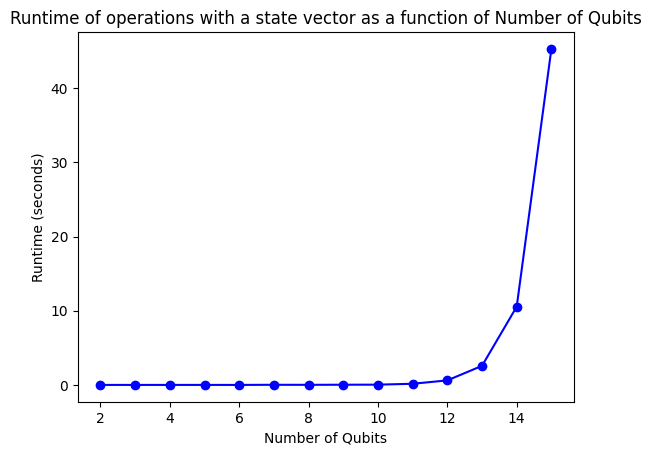

In [30]:
#Retrieve the qubits and runtimes for plotting
qubits = list(sv_results.keys())
runtimes = [sv_results[n][0] for n in qubits]

# Plotting the data
plt.plot(qubits, runtimes, marker='o', linestyle='-', color='b')

# Adding labels and title
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime of operations with a state vector as a function of Number of Qubits')

In [3]:
def init_tensor(num_qubits: int) -> np.array:
    """Initialize the state vector and set the value to zero"""
    st = np.zeros((2,)*num_qubits)
    # init state vector to 0
    st[(0,)*num_qubits] = 1
    return st

In [4]:
def tensor_operation(operation, qubits, state_tensor: np.array) -> np.array:
    """Performs the operation on the tensor representation 

    Args:
        operation: Operation to perform
        qubits: an int or list of ints representing the qubits to be acted on
        state_tensor: current state in tensor form

    Returns:
        The new state as a vector after the operation
    """
    qubits = [qubits] if isinstance(qubits, int) else qubits

    total_number_qubits = len(np.shape(state_tensor))

    # Handle error cases
    if len(qubits) > 2:
        raise AttributeError("qubits can contain at max 2 values")
    elif(len(qubits) == 2 and not np.array_equal(operation, CNOT)):
        raise AttributeError("only 2 qubit gate is CNOT")
    elif(not all(q in range(1, total_number_qubits+1) for q in qubits)):
        raise AttributeError("Qubits to act upon are not valid. If an operation acts upon a single qubit please enter an integer. If the operation acts on two qubit, include a list of integers with the first integer being the control and the second integer being the target.")

    # Handle CNOT case
    elif(len(qubits) == 2):
        temp_state_tensor = np.moveaxis(state_tensor, [qubits[0]-1, qubits[1]-1], [0, 1])
        shaped_state_tensor = np.reshape(temp_state_tensor, (4,) + (2,)*(temp_state_tensor.ndim-2)) 

        after_cnot_state = np.tensordot(operation, shaped_state_tensor, axes=([1], [0]))
        new_shaped_state = np.reshape(after_cnot_state, (2, 2) + (2,) *(temp_state_tensor.ndim-2))
        return np.moveaxis(new_shaped_state, [0,1], [qubits[0]-1, qubits[1]-1])
    
    # Handle single qubit operations
    else:
        temp_state_tensor = np.tensordot(operation, state_tensor, axes=(1, qubits[0]-1))
        return np.moveaxis(temp_state_tensor, 0, qubits[0]-1)

In [5]:
num_qubits =3
state_tensor = init_tensor(num_qubits)
state_tensor = tensor_operation(X, 1, state_tensor)
state_tensor = tensor_operation(H, 1, state_tensor)
state_tensor = tensor_operation(CNOT, [1,2], state_tensor)
print(state_tensor)


[[[ 0.70710678  0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [-0.70710678  0.        ]]]


In [6]:
def run_tensor_experiment(num_qubits: int) -> float:
    """Runs the predetermined experiment of X, H, and CNOT operations.
    The time it takes to run the operations is saved and returned
    
    Args:
        num_qubits: how many qubits to use with the experiment
        
    Returns:
        Time in seconds it took to run the operations
    """

    # determine control and target qubits at random before starting
    control_qubit, target_qubit = np.random.choice(range(1, num_qubits+1), size=2, replace=False)
    x_qubit = np.random.choice(range(1, num_qubits+1), 1)
    h_qubit = np.random.choice(range(1, num_qubits+1), 1)
    start_time = time.time()
    state_tensor = init_tensor(num_qubits)
    state_tensor = tensor_operation(X, x_qubit, state_tensor)
    state_tensor = tensor_operation(H, h_qubit, state_tensor)
    state_tensor = tensor_operation(CNOT, [control_qubit, target_qubit], state_tensor)
    return time.time()-start_time, control_qubit, target_qubit
    

In [7]:
results = {}

# Starting at 32 qubits the kernel crashes
for num_qubits in range(2, 32):
    results[num_qubits] = run_tensor_experiment(num_qubits)

for qubit, result in results.items():
    print(f"{qubit} qubits - {result[0]} seconds")

ValueError: repeated axis in `source` argument

In [ ]:
results